<img src='harrypotter_image.png' width='200px' style="float:left;margin-right:10pt"></img>
## Illustration of NWHypergraph <-> HyperNetX exchange using PyBind and Kaggle's HarryPotter dataset.

In this tutorial we introduce `hypernetx.StaticEntity` and `hypernetx.StaticEntitySet` and the new `static=True` attribute in the `hypernetx.Hypergraph` class. 

Harry Potter Data is available here: https://www.kaggle.com/gulsahdemiryurek/harry-potter-dataset.

Python code for parsing the dataset is in `harrypotter.py` in this tutorial's directory.

In [1]:
import hypernetx as hnx
import matplotlib.pyplot as plt
from collections import OrderedDict, defaultdict
import scipy
from scipy.sparse import coo_matrix, csr_matrix, issparse
import pandas as pd
import numpy as np
import itertools as it
import sys
from harrypotter import HarryPotter

In [2]:
hogwarts = HarryPotter()

### The Harry Potter Dataset:
We have edited the dataset so that it has 5 categories and every cell is filled. Where a value is unknown, we marked it as "Unknown *category_name*". 

In [3]:
hogwarts.dataframe

,House,Blood status,Species,Hair colour,Eye colour
Id,,,,,
1,Gryffindor,Half-blood,Human,Black,Bright green
2,Gryffindor,Pure-blood,Human,Red,Blue
3,Gryffindor,Muggle-born,Human,Brown,Brown
4,Gryffindor,Half-blood,Human,Silver| formerly auburn,Blue
5,Gryffindor,Part-Human,Half-Human/Half-Giant,Black,Black
...,...,...,...,...,...
136,Unknown House,Unknown Blood status,Human,Grey,Unknown Eye colour
137,Unknown House,Unknown Blood status,Werewolf,Grey,Unknown Eye colour
138,Unknown House,Pure-blood or half-blood,Human,Blond,Blue


**We define a labeling based on the categories and store it in an OrderedDict.**   
The ordering of labels is determined by their order of appearance in the table with the exception of Unknown labels, which are always listed first.

In [4]:
hogwarts.labels

OrderedDict([('House',
              array(['Unknown House', 'Gryffindor', 'Ravenclaw', 'Slytherin',
                     'Hufflepuff', 'Beauxbatons Academy of Magic',
                     'Durmstrang Institute'], dtype='<U28')),
             ('Blood status',
              array(['Unknown Blood status', 'Half-blood', 'Pure-blood', 'Muggle-born',
                     'Part-Human', 'Pure-blood or half-blood', 'Part-Goblin',
                     'Muggle-born or half-blood', 'Quarter-Veela', 'Muggle', 'Squib'],
                    dtype='<U25')),
             ('Species',
              array(['Unknown Species', 'Human', 'Half-Human/Half-Giant', 'Werewolf',
                     'Human (Werewolf traits)', 'Human(goblin ancestry)', 'Ghost',
                     'Centaur', 'Human (Metamorphmagus)', 'Elf'], dtype='<U23')),
             ('Hair colour',
              array(['Unknown Hair colour', 'Black', 'Red', 'Brown',
                     'Silver| formerly auburn', 'Blond', 'Sandy', 'Auburn',
 

**We next create a tensor with dimension equal to the number of categories and indexed by the labels.** 
We remove duplicate rows and create a boolean 0-1 tensor.
A 1 in entry $(x_0,x_1,x_2,x_3,x_4, x_5)$ indicates that there is a record in the data corresponding to:
$
\text{'House':hogwarts.labels['House']}[x_0],\text{'Blood Status':hogwarts.labels['Blood Status']}[x_1]\text{...etc...}
$

The tensor may be stored as a list of its nonzero indices, or in a sparse format taking the transpose of that list, or as a `numpy.ndarray`.

In [5]:
## List of nonzero indices
hogwarts.data

array([[ 0,  0,  0,  0,  0],
       [ 0,  0,  1,  0,  0],
       [ 0,  0,  1,  1,  0],
       [ 0,  0,  1,  1,  3],
       [ 0,  0,  1,  1,  4],
       [ 0,  0,  1,  2,  3],
       [ 0,  0,  1, 19,  0],
       [ 0,  0,  1, 19, 25],
       [ 0,  0,  1, 26, 18],
       [ 0,  0,  3, 19,  0],
       [ 0,  0,  6, 20,  4],
       [ 0,  0,  7, 16, 15],
       [ 0,  0,  9,  0,  0],
       [ 0,  1,  1, 19, 22],
       [ 0,  1,  1, 29,  3],
       [ 0,  2,  1,  2,  7],
       [ 0,  2,  1, 15,  0],
       [ 0,  2,  1, 18,  4],
       [ 0,  2,  1, 19,  0],
       [ 0,  2,  1, 19, 17],
       [ 0,  2,  1, 27, 20],
       [ 0,  2,  1, 31, 23],
       [ 0,  5,  1,  0,  0],
       [ 0,  5,  1,  1,  0],
       [ 0,  5,  1,  3, 19],
       [ 0,  5,  1,  5,  2],
       [ 0,  5,  1, 10,  9],
       [ 0,  5,  1, 15,  0],
       [ 0,  5,  1, 19,  0],
       [ 0,  5,  1, 21, 14],
       [ 0,  5,  1, 25,  0],
       [ 0,  5,  1, 30,  3],
       [ 0,  9,  1,  1,  0],
       [ 0,  9,  1,  5,  2],
       [ 0,  9

In [6]:
hogwarts.data.shape

(126, 5)

In [7]:
## sparse tensor format
hogwarts.data.transpose()

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  6],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  2,
         2,  2,  2,  2,  2,  2,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
         9,  9,  9,  9, 10,  0,  0,  1,  1,  1,  1,  1,  1,  1,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  4,  5,
         5,  5,  5,  5,  5,  5,  5,  0,  1,  1,  1,  1,  1,  3,  5,  5,
         5,  5,  5,  5,  5,  6,  7,  1,  1,  1,  1,  1,  2,  2,  2,  2,

In [8]:
## numpy.ndarray - note this will not be the way we store the data for our eventual release. 
## Rather, we will use a sparse format as in the last cell.
hogwarts.arr

array([[[[[1, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]],

         [[1, 0, 0, ..., 0, 0, 0],
          [1, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]],

         [[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]],

         ...,

         [[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]],

         [[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
       

In [9]:
hogwarts.arr.shape

(7, 11, 10, 36, 26)

In [10]:
## The sparse format is preferred so a supplied array will be rewritten in this form
## If an array is supplied the labels should correspond to the indices already, 
## so no renumbering should be done
data_from_array = dfa = np.array(hogwarts.arr.nonzero()).transpose()
data_from_array.shape

(126, 5)

In [11]:
[max(x)+1 for x in dfa.transpose()]

[7, 11, 10, 36, 26]

In [12]:
## Confirm that we have the same data when we retrieve it from the array
np.allclose(np.sort(dfa,axis=0), np.sort(hogwarts.data, axis=0))

True

### StaticEntity and StaticEntitySet

The entire dataset has now been represented using a data array or tensor array and a dictionary associating positions in the tensor array and values in the data array with values in the original data.

The basic object in HyperNetX, which holds the data and label dictionary, is a `StaticEntity`.

Each dimension of the array, is considered a "level" in the StaticEntity. A level's order corresponds to its position in the datatable. In terms of the original Entity structure in HyperNetX, levels reference an order of containment. Elements of the the 2nd level belong to elements in the 1st column and so on.  The order of levels is given by the order of keys in the labels:

In [13]:
E = hnx.StaticEntity(arr = hogwarts.arr, labels = hogwarts.labels)
E.keys

array(['House', 'Blood status', 'Species', 'Hair colour', 'Eye colour'],
      dtype='<U12')

**Using the same nomenclature as `hypernetx.Entity`, the elements of a StaticEntity refer to the first level and its children refer to the second level.**

In [14]:
E = hnx.StaticEntity(arr=hogwarts.arr, labels=hogwarts.labels)
E.uidset,E.elements,E.children

(('Unknown House',
  'Gryffindor',
  'Ravenclaw',
  'Slytherin',
  'Hufflepuff',
  'Beauxbatons Academy of Magic',
  'Durmstrang Institute'),
 OrderedDict([('Unknown House',
               ['Unknown Blood status',
                'Half-blood',
                'Pure-blood',
                'Pure-blood or half-blood',
                'Muggle',
                'Squib']),
              ('Gryffindor',
               ['Unknown Blood status',
                'Half-blood',
                'Pure-blood',
                'Muggle-born',
                'Part-Human',
                'Pure-blood or half-blood']),
              ('Ravenclaw',
               ['Unknown Blood status',
                'Half-blood',
                'Muggle-born',
                'Pure-blood or half-blood',
                'Part-Goblin',
                'Muggle-born or half-blood']),
              ('Slytherin',
               ['Half-blood', 'Pure-blood', 'Pure-blood or half-blood']),
              ('Hufflepuff',
           

**Levels can be reordered and any pair of columns may be organized to be elements and children.**

In [15]:
E.elements_by_level(level1=2,level2=3,translate=True)

OrderedDict([('Unknown Species', ['Unknown Hair colour']),
             ('Human',
              ['Unknown Hair colour',
               'Black',
               'Red',
               'Brown',
               'Silver| formerly auburn',
               'Blond',
               'Sandy',
               'Auburn',
               'Colourless and balding',
               'Dark',
               'Mousy',
               'Dirty-blonde',
               'Reddish-blonde',
               'Blonde',
               'White-blond',
               'Iron grey',
               'Bald',
               'Grey',
               'Straw blond',
               'Variable',
               'Red brown',
               'Brown/greying',
               'Silver| formerly black',
               'Tawny',
               'Silver',
               'Silvery-blonde',
               'Ginger',
               'Straw-coloured',
               'Red ',
               'Reddish-brown',
               'Mousy brown',
               'Jet-black',
   

In [16]:
F = E.restrict_to_levels([2,3,1]) ## This generates a new StaticEntity
F.labels


OrderedDict([('Species',
              array(['Unknown Species', 'Human', 'Half-Human/Half-Giant', 'Werewolf',
                     'Human (Werewolf traits)', 'Human(goblin ancestry)', 'Ghost',
                     'Centaur', 'Human (Metamorphmagus)', 'Elf'], dtype='<U23')),
             ('Hair colour',
              array(['Unknown Hair colour', 'Black', 'Red', 'Brown',
                     'Silver| formerly auburn', 'Blond', 'Sandy', 'Auburn',
                     'Light brown flecked with grey', 'Colourless and balding', 'Dark',
                     'Mousy', 'Dirty-blonde', 'White', 'Reddish-blonde', 'Blonde',
                     'White-blond', 'Iron grey', 'Bald', 'Grey', 'White (balding)',
                     'Straw blond', 'Variable', 'Red brown', 'Brown/greying',
                     'Silver| formerly black', 'Tawny', 'Silver', 'Silvery-blonde',
                     'Ginger', 'Straw-coloured', 'Red ', 'Reddish-brown', 'Mousy brown',
                     'Jet-black', 'White blo

In [17]:
F.uidset

('Unknown Species',
 'Human',
 'Half-Human/Half-Giant',
 'Werewolf',
 'Human (Werewolf traits)',
 'Human(goblin ancestry)',
 'Ghost',
 'Centaur',
 'Human (Metamorphmagus)',
 'Elf')

### A StaticEntitySet is a StaticEntity restricted to two levels. 
By default, a StaticEntity will grab the 1st two dimensions of the of the array and first two keys of the labels, but any pair of levels may be specified. 

In [18]:
ES = hnx.StaticEntitySet(data=hogwarts.data, labels=hogwarts.labels, level1=0, level2=1)

In [19]:
ES = hnx.StaticEntitySet(E)
ES.labels

OrderedDict([('House',
              array(['Unknown House', 'Gryffindor', 'Ravenclaw', 'Slytherin',
                     'Hufflepuff', 'Beauxbatons Academy of Magic',
                     'Durmstrang Institute'], dtype='<U28')),
             ('Blood status',
              array(['Unknown Blood status', 'Half-blood', 'Pure-blood', 'Muggle-born',
                     'Part-Human', 'Pure-blood or half-blood', 'Part-Goblin',
                     'Muggle-born or half-blood', 'Quarter-Veela', 'Muggle', 'Squib'],
                    dtype='<U25'))])

## Static Hypergraph
A static hypergraph is one where all nodes and edges are known at the time of construction. This permits an internal ordering and uid structure for easy reference and faster computation of metrics.

The nodes and edges of a static Hypergraph are stored using the StaticEntitySet structure. 

A static Hypergraph may be instantiated by adding the keyword argument `static=True`. Hypergraphs have `static=False` by default. A static Hypergraph may be created with a set system of the form:
1. *dict* with static=True 
2. *iterable of iterables* with static=True, 
3. `hypernetx.EntitySet` with static=True
4. `hypernetx.StaticEntity` (static is automatically set to True),
5. `hypernetx.StaticEntitySet` (static is automatically set to True).


In [20]:
## example, instantiate from a dictionary
d = E.elements
Hdict = hnx.Hypergraph(d,static=True)

## in this case the keys will be integers
Hdict.edges.labels

OrderedDict([('0',
              array(['Unknown House', 'Gryffindor', 'Ravenclaw', 'Slytherin',
                     'Hufflepuff', 'Beauxbatons Academy of Magic',
                     'Durmstrang Institute'], dtype='<U28')),
             ('1',
              array(['Unknown Blood status', 'Half-blood', 'Pure-blood',
                     'Pure-blood or half-blood', 'Muggle', 'Squib', 'Muggle-born',
                     'Part-Human', 'Part-Goblin', 'Muggle-born or half-blood',
                     'Quarter-Veela'], dtype='<U25'))])

In [21]:
## Create a StaticEntitySet from an StaticEntity (restricts to two columns)
ESE = hnx.StaticEntitySet(entity=E)
ESE.incidence_matrix().todense()
ESE.keys

array(['House', 'Blood status'], dtype='<U12')

In [22]:
## Create a hypergraph from a StaticEntity
HE = hnx.Hypergraph(E)
HE.dataframe()

,Beauxbatons Academy of Magic,Durmstrang Institute,Gryffindor,Hufflepuff,Ravenclaw,Slytherin,Unknown House
Half-blood,0,0,1,1,1,1,1
Muggle,0,0,0,0,0,0,1
Muggle-born,0,0,1,1,1,0,0
Muggle-born or half-blood,0,0,0,0,1,0,0
Part-Goblin,0,0,0,0,1,0,0
Part-Human,1,0,1,0,0,0,0
Pure-blood,0,0,1,1,0,1,1
Pure-blood or half-blood,0,1,1,1,1,1,1
Quarter-Veela,1,0,0,0,0,0,0
Squib,0,0,0,0,0,0,1


In [23]:
HF = hnx.Hypergraph(F)  ## F restricted to columns [2,3,1] so the hypergraph will be on columns 2 and 3
HF.dataframe()

,Centaur,Elf,Ghost,Half-Human/Half-Giant,Human,Human (Metamorphmagus),Human (Werewolf traits),Human(goblin ancestry),Unknown Species,Werewolf
Auburn,0,0,0,0,1,0,0,0,0,0
Bald,0,0,0,0,1,0,0,0,0,0
Black,0,0,1,1,1,0,0,0,0,0
Blond,0,0,0,0,1,0,0,0,0,0
Blonde,0,0,0,0,1,0,0,0,0,0
Brown,0,0,1,1,1,0,0,0,0,0
Brown/greying,0,0,0,0,1,0,0,0,0,0
Colourless and balding,0,0,0,0,1,0,0,0,0,0
Dark,0,0,0,0,1,0,0,0,0,0
Dirty-blonde,0,0,0,0,1,0,0,0,0,0


In [24]:
## example, instantiate from an EntitySet
H = hnx.Hypergraph(ESE)
H.edges

StaticEntitySet(None,['Unknown House', 'Gryffindor', 'Ravenclaw', 'Slytherin', 'Hufflepuff', 'Beauxbatons Academy of Magic', 'Durmstrang Institute'],{})

In [25]:
H.incidence_matrix()

<11x7 sparse matrix of type '<class 'numpy.int64'>'
	with 29 stored elements in Compressed Sparse Row format>

In [26]:
H.dataframe()

,Beauxbatons Academy of Magic,Durmstrang Institute,Gryffindor,Hufflepuff,Ravenclaw,Slytherin,Unknown House
Half-blood,0,0,1,1,1,1,1
Muggle,0,0,0,0,0,0,1
Muggle-born,0,0,1,1,1,0,0
Muggle-born or half-blood,0,0,0,0,1,0,0
Part-Goblin,0,0,0,0,1,0,0
Part-Human,1,0,1,0,0,0,0
Pure-blood,0,0,1,1,0,1,1
Pure-blood or half-blood,0,1,1,1,1,1,1
Quarter-Veela,1,0,0,0,0,0,0
Squib,0,0,0,0,0,0,1


**Restrict to specific edges and nodes as before**

In [27]:
## Restrict to edges
HH = H.restrict_to_edges(['Gryffindor','Ravenclaw','Slytherin','Hufflepuff'])
HH.dataframe()

,Gryffindor,Hufflepuff,Ravenclaw,Slytherin
Half-blood,1,1,1,1
Muggle-born,1,1,1,0
Muggle-born or half-blood,0,0,1,0
Part-Goblin,0,0,1,0
Part-Human,1,0,0,0
Pure-blood,1,1,0,1
Pure-blood or half-blood,1,1,1,1
Unknown Blood status,1,1,1,0


In [28]:
## Restrict to nodes
nodelist = [nd for nd in HH.nodes if 'pure' in str(nd).lower()]
HHD = HH.restrict_to_nodes(nodelist)
HHD.dataframe()

,Gryffindor,Hufflepuff,Ravenclaw,Slytherin
Pure-blood,1,1,0,1
Pure-blood or half-blood,1,1,1,1


In [29]:
## Or restrict first then create the hypergraph
J = ES.restrict_to_indices([1,2,3,4])
HJ = hnx.Hypergraph(J)
HJ.dataframe()

,Gryffindor,Hufflepuff,Ravenclaw,Slytherin
Half-blood,1,1,1,1
Muggle-born,1,1,1,0
Muggle-born or half-blood,0,0,1,0
Part-Goblin,0,0,1,0
Part-Human,1,0,0,0
Pure-blood,1,1,0,1
Pure-blood or half-blood,1,1,1,1
Unknown Blood status,1,1,1,0


**A Hypergraph with static=True may be converted to a static=False hypergraph if dynamic properties or visualizations are needed.**  
(Similarly any hypergraph may be converted to a static hypergraph using its incidence_dict.)

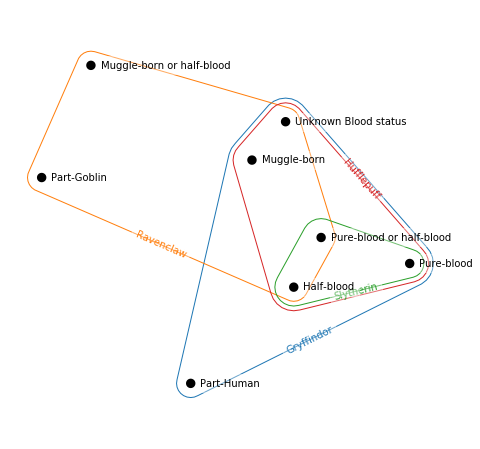

In [30]:
HJD = HJ.remove_static()
hnx.draw(HJD)